In [11]:
# fmt: off
from Interpretability.ModelAugmentation import *
from Interpretability.InterpretabilityMethods import *
from SequentialLearning.SequentialTasks.MNISTClassificationTask import MNISTClassificationTask
from SequentialLearning.EWC_Methods.EWC_Methods import *

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import tensorflow as tf
# fmt: on
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [10]:
MODEL_SAVE_PATH = "models/mnist_intepretability_model"
LOAD_MODEL = False
TRAIN_MODEL = not LOAD_MODEL

task_digit_labels = [0,1]
epochs = 5
training_batches = 300
validation_batches = 100
batch_size = 32
ewc_method = EWC_Method.FISHER_MATRIX

# Model Training and Architecture

In [12]:
model: tf.keras.Model
if LOAD_MODEL and os.path.exists(MODEL_SAVE_PATH):
    # Try to load model directly, if one exists
    print("LOADING MODEL")
    model = tf.keras.models.load_model(MODEL_SAVE_PATH)  # type: ignore
else:
    # Otherwise, make an entire new model!
    print("CREATING MODEL")
    model_input_shape = (28,28,1)
    model_inputs = model_layer = tf.keras.Input(shape=model_input_shape)
    model_layer = tf.keras.layers.Conv2D(12, (5,5), activation="relu", name="conv2d_1")(model_layer)
    model_layer = tf.keras.layers.MaxPool2D((2,2))(model_layer)
    model_layer = tf.keras.layers.Conv2D(12, (3,3), activation="relu", name="conv2d_2")(model_layer)
    model_layer = tf.keras.layers.Conv2D(9, (3,3), activation="relu", name="conv2d_3")(model_layer)
    model_layer = tf.keras.layers.Flatten()(model_layer)
    model_layer = tf.keras.layers.Dense(10, activation="relu")(model_layer)
    model_layer = tf.keras.layers.Dense(len(task_digit_labels))(model_layer)

    model = tf.keras.Model(inputs=model_inputs, outputs=model_layer, name="base_model")

# if len(task_digit_labels) == 2:
#     loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
# else:
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
model.summary()

CREATING MODEL
Model: "base_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 12)        312       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 12)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 12)        1308      
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 9)           981       
                                                                 
 flatten (Flatten)           (None, 576)               0         
                                         

In [13]:
task = MNISTClassificationTask(
        name=f"Task 0",
        model=model,
        model_base_loss=loss_fn,
        task_digit_labels=task_digit_labels,
        training_batches = training_batches,
        validation_batches = validation_batches,
        batch_size=batch_size
    )
ewc_term_creator = EWC_Term_Creator(ewc_method, model, [task])

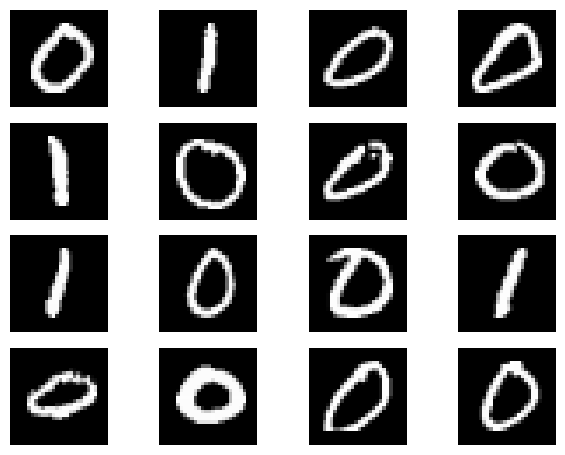

In [60]:
# Show some images from the task dataset
data = task.validation_dataset.take(1)
data_images, data_labels = data.as_numpy_iterator().next()
data_images = data_images[:16]
data_labels = data_labels[:16]
plot_images(data_images, cmap="gray")

In [15]:
if TRAIN_MODEL:
    checkpoint_path = MODEL_SAVE_PATH+"/checkpoint"
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        verbose=1)
    history = task.train_on_task(epochs=epochs, callbacks=[
#         checkpoint_callback, 
        *ewc_term_creator.callback_dict.values(),
    ])
    model.save(MODEL_SAVE_PATH)
else:
    print(f"{TRAIN_MODEL=}")

Epoch 1/5
300/300 [==============================] - 13s 26ms/step - loss: 0.0517 - base_loss: 0.0517 - val_loss: 0.0029 - val_base_loss: 0.0029
Epoch 2/5
300/300 [==============================] - 5s 16ms/step - loss: 0.0034 - base_loss: 0.0034 - val_loss: 0.0054 - val_base_loss: 0.0054
Epoch 3/5
300/300 [==============================] - 8s 23ms/step - loss: 0.0041 - base_loss: 0.0041 - val_loss: 0.0025 - val_base_loss: 0.0025
Epoch 4/5
300/300 [==============================] - 6s 15ms/step - loss: 0.0014 - base_loss: 0.0014 - val_loss: 0.0025 - val_base_loss: 0.0025
Epoch 5/5
300/300 [==============================] - 6s 16ms/step - loss: 4.4852e-04 - base_loss: 4.4852e-04 - val_loss: 0.0021 - val_base_loss: 0.0021
--------------------------------------------------------------------------------
STARTING FISHER CALCULATION
FINISHED FISHER CALCULATION
--------------------------------------------------------------------------------


INFO:tensorflow:Assets written to: models/mnist_intepretability_model/assets


INFO:tensorflow:Assets written to: models/mnist_intepretability_model/assets


In [64]:
ewc_term = ewc_term_creator.create_term(ewc_lambda = 1)
threshold_model = threshold_by_omega(task.model, ewc_term.omega_matrix, threshold_percentage=0.3, comparison_method=ComparisonMethod.LAYER_WISE)

LAYER_WISE layer_index=1 threshold_value=1.8516294
LAYER_WISE layer_index=3 threshold_value=0.22093903
LAYER_WISE layer_index=4 threshold_value=0.41258422
LAYER_WISE layer_index=6 threshold_value=1.6984599e-05
LAYER_WISE layer_index=7 threshold_value=0.18402912


## Validation Testing

In [65]:
print(f"ORIGINAL  MODEL: {task.model.evaluate(task.validation_dataset, steps=task.validation_batches, return_dict=True)}")
print(f"THRESHOLD MODEL: {threshold_model.evaluate(task.validation_dataset, steps=task.validation_batches, return_dict=True)}")

100/100 [==============================] - 2s 12ms/step - loss: 0.0030 - base_loss: 0.0030
ORIGINAL  MODEL: {'loss': 0.0030235343147069216, 'base_loss': 0.0030235343147069216}
100/100 [==============================] - 1s 8ms/step - loss: 0.0013
THRESHOLD MODEL: {'loss': 0.001311739906668663}


# Interpretability Methods

## Kernel Inspection

OPERATING ON conv2d_1


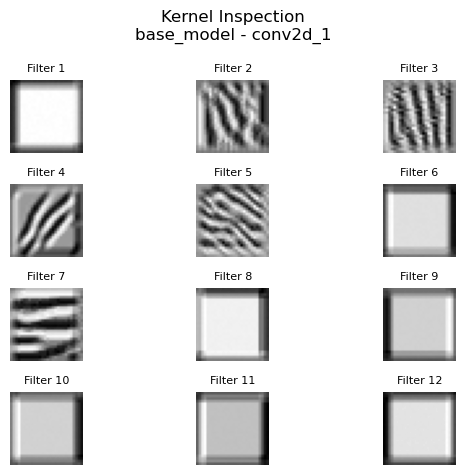

OPERATING ON conv2d_2


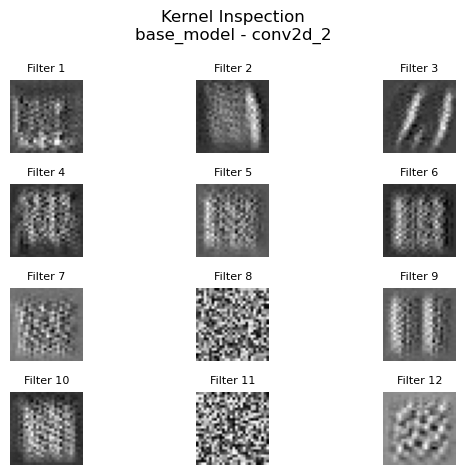

OPERATING ON conv2d_3


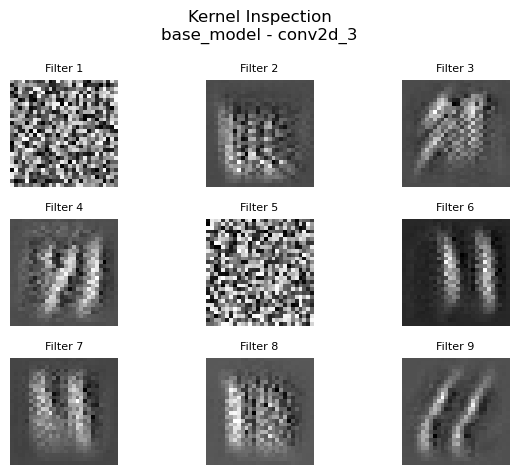

In [70]:
kernel_inspection(model=task.model, steps=500, step_size=0.1, layer_name="conv2d_1")
kernel_inspection(model=task.model, steps=500, step_size=0.1, layer_name="conv2d_2")
kernel_inspection(model=task.model, steps=500, step_size=0.1, layer_name="conv2d_3")

OPERATING ON conv2d_1


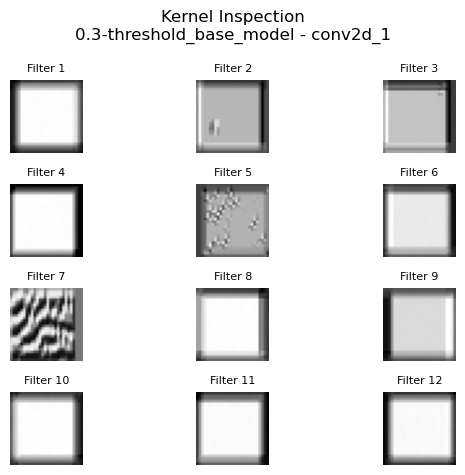

OPERATING ON conv2d_2


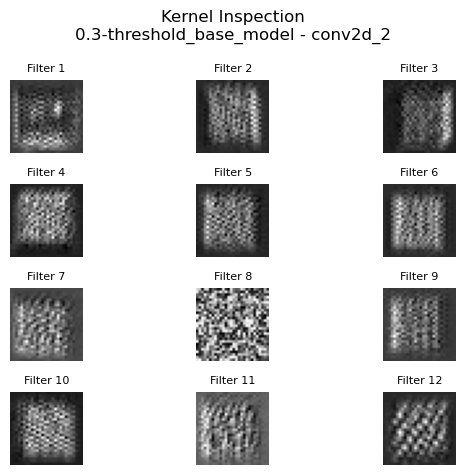

OPERATING ON conv2d_3


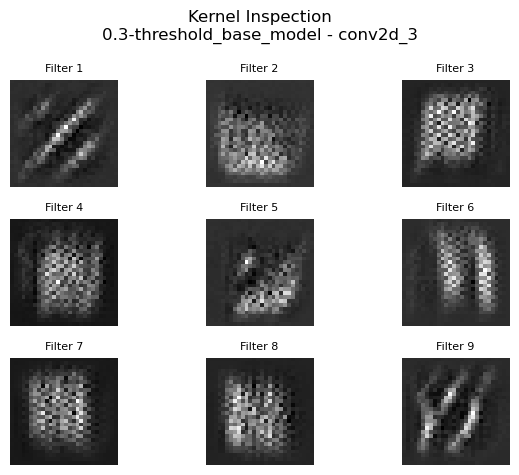

In [69]:
kernel_inspection(model=threshold_model, steps=500, step_size=0.1, layer_name="conv2d_1")
kernel_inspection(model=threshold_model, steps=500, step_size=0.1, layer_name="conv2d_2")
kernel_inspection(model=threshold_model, steps=500, step_size=0.1, layer_name="conv2d_3")

## Occlusion Sensitivity

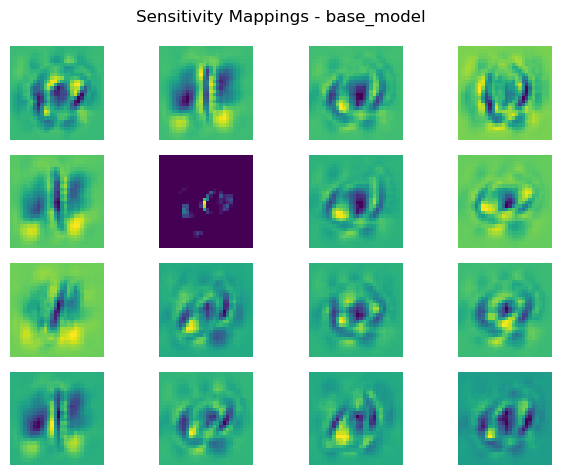

In [21]:
occlusion_sensitivity(task.model, data_images, data_labels, patch_size=2, stride=1)

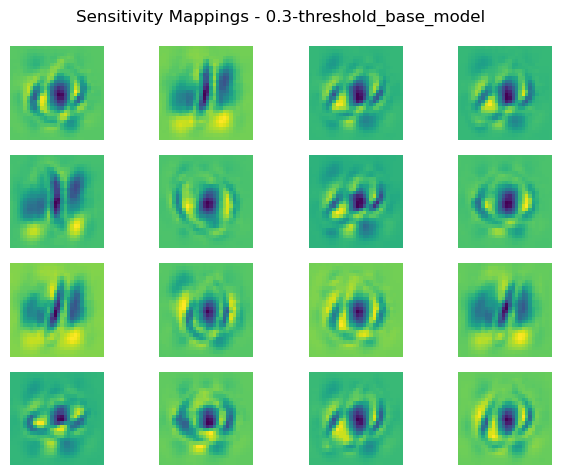

In [68]:
occlusion_sensitivity(threshold_model, data_images, data_labels, patch_size=2, stride=1)

## GRADCAM

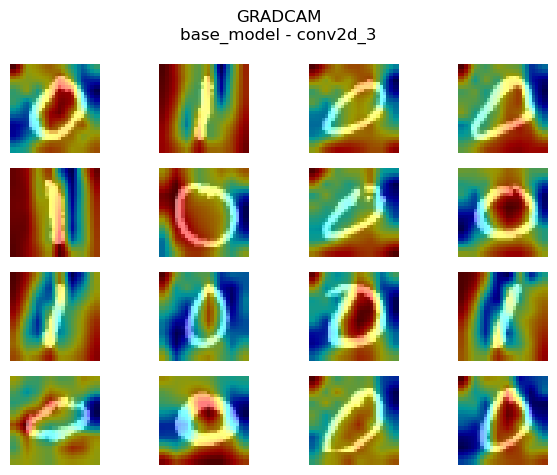

In [67]:
GRADCAM(task.model, data_images, data_labels, layer_name="conv2d_3", show_predictions=0)

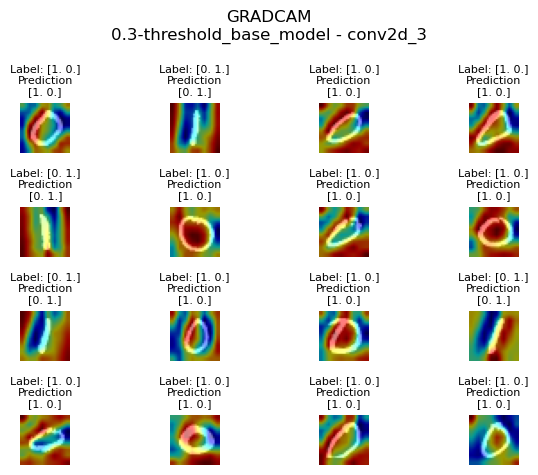

In [66]:
GRADCAM(threshold_model, data_images, data_labels, layer_name="conv2d_3", show_predictions=2)